In [68]:
import os

if "README.md" not in os.listdir():
    os.chdir("../")

In [69]:
import re

import pandas as pd
from bs4 import BeautifulSoup


pd.set_option("display.width", 1000)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 100)

In [70]:
df = pd.read_csv("./data/raw/markup.csv", sep="\t")

In [71]:
df.head(5)

,DocName,Tokens,KE_0,KE_1,KE_2,KE_3,KE_4,Blocks_0,Blocks_1,Blocks_2,Blocks_3
0,Протокол ВОСА № 2 от 19_12_2013.html.txt,о,O,O,O,O,O,O,O,O,O
1,Протокол ВОСА № 2 от 19_12_2013.html.txt,',O,O,O,O,O,O,O,O,O
2,Протокол ВОСА № 2 от 19_12_2013.html.txt,«,O,O,O,O,O,O,O,O,O
3,Протокол ВОСА № 2 от 19_12_2013.html.txt,•,O,O,O,O,O,O,O,O,O
4,Протокол ВОСА № 2 от 19_12_2013.html.txt,ДВЭУК,O,O,O,O,O,O,O,O,O


ДВЭУК - это явно имеет отношение к названию юридческого лица

### Аналитика и визуализация

Анализ можно сделать по нескольким направлениям:
- Распределение именованных сущностей и блоков, в том числе внутри друг друга.
- Как часто встречаются те или иные блоки

In [72]:
# сделаем датасет без профиксов для удобства анализа
def func(record):
    columns = record.index
    res = []
    for i in columns:
        res.append(record[i].removeprefix("B-").removeprefix("I-"))
    return res


df_not_prefix = df.apply(func, axis=1, result_type="expand")
df_not_prefix.columns = df.columns

In [73]:
pd.set_option("display.max_rows", 2000)
pd.DataFrame(
    df_not_prefix[["KE_0", "KE_1", "KE_2", "KE_3", "KE_4"]].value_counts()
).sort_values(by=["KE_0", "KE_1", "KE_2", "KE_3", "KE_4"])

count
KE_0              KE_1                 KE_2      KE_3                   KE_4                          
O                 O                    O         O                      O                        59905
                                                                        Адрес-СубъектРФ              5
                                                                        Цифры-БазаОпред             70
                                                                        Цифры-единица_измерения     38
                                                                        Цифры-оператор               7
                                                                        Цифры-цифры_номером         23
                                                                        Цифры-цифры_прописью         7
                                                 Адрес                  O                          886
                                                                        Адрес-Дом                  501
                                                                        Адрес-Индекс                69
                                                                        Адрес-НасПункт             154
                                                                        Адрес-СубъектРФ            305
                                                                        Адрес-Улица                324
                                                                        Цифры-цифры_номером          1
                                                 Цифры_Длительность     O                           34
                                                                        Цифры-БазаОпред             16
                                                                        Цифры-единица_измерения     55
                                                                        Цифры-оператор              48
                                                                        Цифры-цифры_номером         52
                                                                        Цифры-цифры_прописью        11
                                                 Цифры_Иная цифра       O                            1
                                                                        Цифры-единица_измерения     18
                                                                        Цифры-цифры_номером          1
                                                                        Цифры-цифры_прописью        18
                                                 Цифры_Кол-во           O                          646
                                                                        Цифры-БазаОпред             15
                                                                        Цифры-единица_измерения    761
                                                                        Цифры-оператор              34
                                                                        Цифры-цифры_номером       4187
                                                                        Цифры-цифры_прописью      2154
                                                 Цифры_Номер            O                          515
                                                                        Цифры-БазаОпред            518
                                                                        Цифры-единица_измерения      2
                                                                        Цифры-цифры_номером       1063
                                                                        Цифры-цифры_прописью        30
                                                 Цифры_Номер порядковый O                          931
                                                                        Цифры-БазаОпред           2409
                                                                        Цифры-ед

Как видно из таблицы в данных имеются противоречия, например:
- в KE_3 имеется категория "Адрес", однако у нас есть случаи, когда в KE_3 "O", а в KE_4 "Адрес-СубъектРФ" (5 записей)
- в KE_0 имеется категория "ФизЛицо", однако у нас есть случаи, а в KE_2 "НЮЛ-Наименование" (7 записей)

In [74]:
df_not_prefix[
    (df_not_prefix["KE_3"] == "O") & (df_not_prefix["KE_4"] == "Адрес-СубъектРФ")
]

,DocName,Tokens,KE_0,KE_1,KE_2,KE_3,KE_4,Blocks_0,Blocks_1,Blocks_2,Blocks_3
8679,protocol_gosa_2029.06.2018.html.txt,Московской,O,O,O,O,Адрес-СубъектРФ,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,4_1_ОбсуждениеПовестки->Выслушали_Обсудили
8680,protocol_gosa_2029.06.2018.html.txt,области,O,O,O,O,Адрес-СубъектРФ,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,4_1_ОбсуждениеПовестки->Выслушали_Обсудили
53378,Протокол ГОСА_2016.html.txt,Правительства,O,O,O,O,Адрес-СубъектРФ,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,4_1_ОбсуждениеПовестки->Решили
53379,Протокол ГОСА_2016.html.txt,Хабаровского,O,O,O,O,Адрес-СубъектРФ,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,4_1_ОбсуждениеПовестки->Решили
53380,Протокол ГОСА_2016.html.txt,края,O,O,O,O,Адрес-СубъектРФ,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,4_1_ОбсуждениеПовестки->Решили


In [75]:
df_not_prefix.iloc[8678]

DocName            protocol_gosa_2029.06.2018.html.txt
Tokens                                     Губернатора
KE_0                                                 O
KE_1                                                 O
KE_2                                                 O
KE_3                                                 O
KE_4                                                 O
Blocks_0                             4_Блок_Обсуждение
Blocks_1                                             O
Blocks_2                        4_1_ОбсуждениеПовестки
Blocks_3    4_1_ОбсуждениеПовестки->Выслушали_Обсудили
Name: 8678, dtype: object

In [76]:
df_not_prefix[
    (df_not_prefix["KE_0"] == "ФизЛицо")
    & (df_not_prefix["KE_1"] == "НЮЛ-Наименование")
    & (df_not_prefix["KE_2"] == "O")
    & (df_not_prefix["KE_3"] == "O")
]

,DocName,Tokens,KE_0,KE_1,KE_2,KE_3,KE_4,Blocks_0,Blocks_1,Blocks_2,Blocks_3
2932,Протокол ВОСА № 2 от 19_12_2013.html.txt,Ог,ФизЛицо,НЮЛ-Наименование,O,O,O,10_Блок_Подписи,O,O,O
2933,Протокол ВОСА № 2 от 19_12_2013.html.txt,-,ФизЛицо,НЮЛ-Наименование,O,O,O,10_Блок_Подписи,O,O,O
2934,Протокол ВОСА № 2 от 19_12_2013.html.txt,^,ФизЛицо,НЮЛ-Наименование,O,O,O,10_Блок_Подписи,O,O,O
2935,Протокол ВОСА № 2 от 19_12_2013.html.txt,^,ФизЛицо,НЮЛ-Наименование,O,O,O,10_Блок_Подписи,O,O,O
2936,Протокол ВОСА № 2 от 19_12_2013.html.txt,^,ФизЛицо,НЮЛ-Наименование,O,O,O,10_Блок_Подписи,O,O,O
2937,Протокол ВОСА № 2 от 19_12_2013.html.txt,^,ФизЛицо,НЮЛ-Наименование,O,O,O,10_Блок_Подписи,O,O,O
2938,Протокол ВОСА № 2 от 19_12_2013.html.txt,^,ФизЛицо,НЮЛ-Наименование,O,O,O,10_Блок_Подписи,O,O,O


Здесь имеются случаи неверной разметки:
- в первом случае часть наименования должности (Губернатора Московской области) или наименования гос. органа (Правительства Хабаровского края) определено как адрес субъекта РФ.
- во втором токены не имеющие отношение ни к имени, ни к НЮЛ неверно размечены.

In [77]:
df_not_prefix.columns

Index(['DocName', 'Tokens', 'KE_0', 'KE_1', 'KE_2', 'KE_3', 'KE_4', 'Blocks_0', 'Blocks_1', 'Blocks_2', 'Blocks_3'], dtype='object')

In [78]:
pd.DataFrame(
    df_not_prefix[["Blocks_0", "Blocks_1", "Blocks_2", "Blocks_3"]].value_counts()
).sort_values(by=["Blocks_0", "Blocks_1", "Blocks_2", "Blocks_3", "count"])

count
Blocks_0                  Blocks_1                            Blocks_2               Blocks_3                                                         
10_Блок_Подписи           O                                   O                      O                                                            1001
11_Блок_ЗаверениеКопии    O                                   O                      O                                                             330
1_Блок_Заголовок          O                                   O                      O                                                            7101
2_Блок_Участники          O                                   O                      O                                                            9286
3_Блок_Повестка           O                                   3_1_ПовесткаДня        3_1_ПовесткаДня->Номер                                        370
                                                                                     3_1_ПовесткаДня->Текст                                       2780
                                                                                     O                                                               1
                                                              O                      O                                                             134
4_Блок_Обсуждение         4_Блок_Обсуждение->РезГолосЕдиножды O                      O                                                              42
                          O                                   4_1_ОбсуждениеПовестки 4_1_ОбсуждениеПовестки->Вопрос_поставленный_на_голосование   9268
                                                                                     4_1_ОбсуждениеПовестки->Выслушали_Обсудили                  18287
                                                                                     4_1_ОбсуждениеПовестки->Голосовали                          14257
                                                                                     4_1_ОбсуждениеПовестки->КворумПоВопросу                     21234
                                                                                     4_1_ОбсуждениеПовестки->Номер                                 693
                                                                                     4_1_ОбсуждениеПовестки->Решили                              18091
                                                                                     O                                                            8452
                                                              O                      O                                                            1635
7_Блок_ДопИнформация      O                                   O                      O                                                             123
8_Блок_ПереченьПриложений O                                   O                      O                                                             472
O                         O                                   O                      O                                                             398

Каких-то протеворечий нет

<Axes: >

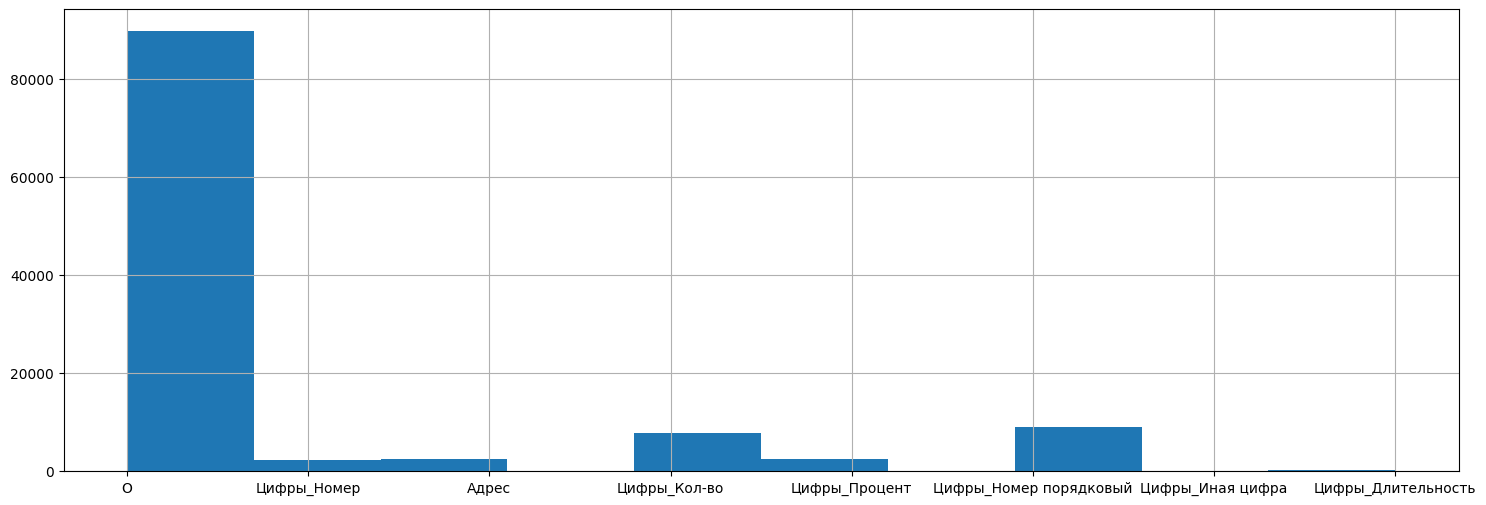

In [79]:
df_not_prefix["KE_3"].hist(figsize=(18, 6))

<Axes: >

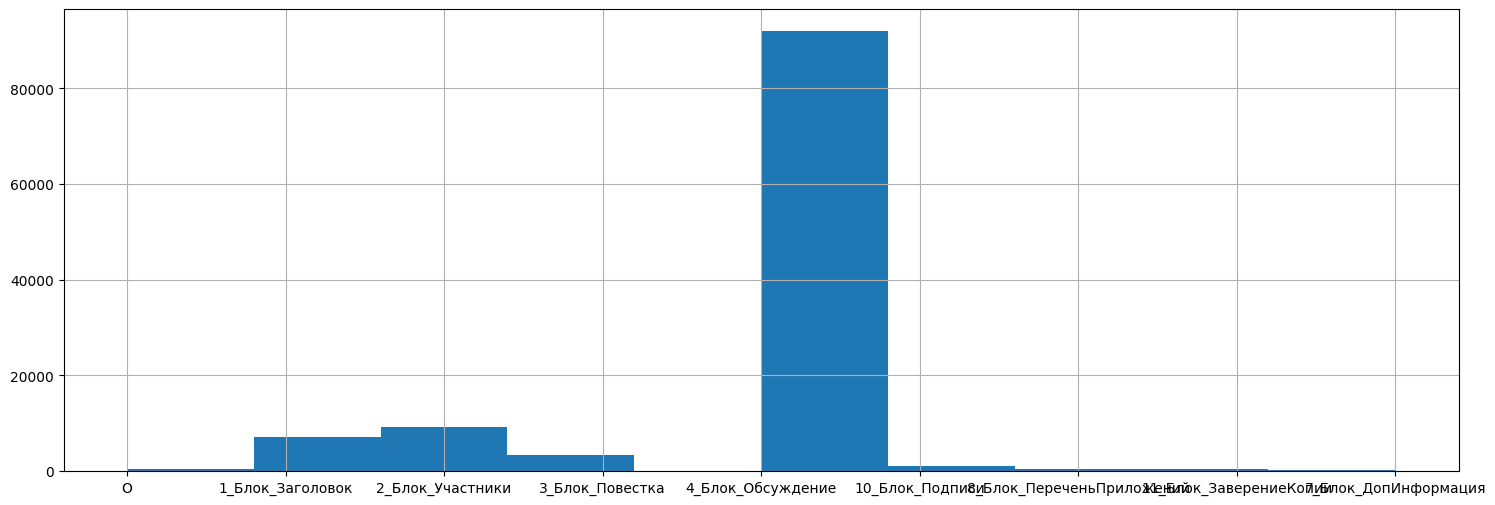

In [80]:
df_not_prefix["Blocks_0"].hist(figsize=(18, 6))

Из характера выявленных именнованых сущностей и их распределения можно сделать вывод, что это документы преимущественно из сферы собраний акционеров

### Поиск возможных ошибок в данных

- Когда один и тот же токен по разному размечается
- Когда конец|середина токена есть, а начала нет

In [81]:
pd.DataFrame(
    df_not_prefix[["Tokens", "KE_0"]]
    .drop_duplicates()
    .groupby("Tokens")["KE_0"]
    .agg(list)
    .sort_values(key=lambda x: x.str.len(), ascending=False)
)[:50]

,KE_0
Tokens,
.,"[O, Дата, НЮЛ, ФизЛицо, Сумма, Время, ГосОрган, Орган_ОСА]"
-,"[O, ФизЛицо, Сумма, ГосОрган, НЮЛ, Время, Орган_ЕИО]"
11,"[O, Дата, Время, Сумма, НЮЛ, Орган_ОСА]"
:,"[O, Время, Орган_ОСА, НЮЛ, Сумма, Дата]"
",","[O, ГосОрган, Дата, ФизЛицо, Сумма, НЮЛ]"
1,"[O, Дата, Сумма, НЮЛ, ФизЛицо]"
7,"[O, Время, Сумма, ГосОрган, Дата]"
и,"[O, ГосОрган, НЮЛ, Орган_ОСА, ФизЛицо]"
России,"[ГосОрган, O, НЮЛ, ФизЛицо]"


Довольно много токенов, категория которых сомнительна, например ':' в НЮЛ или 'Россия', как ФизЛицо

In [82]:
df_not_prefix[(df_not_prefix["Tokens"] == ":") & (df_not_prefix["KE_0"] == "НЮЛ")]

,DocName,Tokens,KE_0,KE_1,KE_2,KE_3,KE_4,Blocks_0,Blocks_1,Blocks_2,Blocks_3
5089,protocol_gosa_18.01.2019.html.txt,:,НЮЛ,НЮЛ-Наименование,O,O,O,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,O
16740,protocol_31.05.2019.html.txt,:,НЮЛ,НЮЛ-Наименование,O,O,O,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,4_1_ОбсуждениеПовестки->Выслушали_Обсудили
84313,voting_report_2019.html.txt,:,НЮЛ,O,O,O,O,2_Блок_Участники,O,O,O
96353,report_itogi_290618.html.txt,:,НЮЛ,НЮЛ-ОПФ,O,O,O,2_Блок_Участники,O,O,O


In [83]:
index = 16740
df_not_prefix.loc[index - 10 : index + 10]

,DocName,Tokens,KE_0,KE_1,KE_2,KE_3,KE_4,Blocks_0,Blocks_1,Blocks_2,Blocks_3
16730,protocol_31.05.2019.html.txt,балета,O,O,O,O,O,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,4_1_ОбсуждениеПовестки->Выслушали_Обсудили
16731,protocol_31.05.2019.html.txt,",",O,O,O,O,O,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,4_1_ОбсуждениеПовестки->Выслушали_Обсудили
16732,protocol_31.05.2019.html.txt,-,O,O,O,O,O,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,4_1_ОбсуждениеПовестки->Выслушали_Обсудили
16733,protocol_31.05.2019.html.txt,фотовыставка,НЮЛ,O,O,O,O,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,4_1_ОбсуждениеПовестки->Выслушали_Обсудили
16734,protocol_31.05.2019.html.txt,под,НЮЛ,O,O,O,O,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,4_1_ОбсуждениеПовестки->Выслушали_Обсудили
16735,protocol_31.05.2019.html.txt,открытым,НЮЛ,НЮЛ-ОПФ,O,O,O,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,4_1_ОбсуждениеПовестки->Выслушали_Обсудили
16736,protocol_31.05.2019.html.txt,небом,НЮЛ,НЮЛ-Наименование,O,O,O,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,4_1_ОбсуждениеПовестки->Выслушали_Обсудили
16737,protocol_31.05.2019.html.txt,«,НЮЛ,НЮЛ-Наименование,O,O,O,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,4_1_ОбсуждениеПовестки->Выслушали_Обсудили
16738,protocol_31.05.2019.html.txt,Русский,НЮЛ,НЮЛ-Наименование,O,O,O,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,4_1_ОбсуждениеПовестки->Выслушали_Обсудили
16739,protocol_31.05.2019.html.txt,балет,НЮЛ,НЮЛ-Наименование,O,O,O,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,4_1_ОбсуждениеПовестки->Выслушали_Обсудили


Неверно размечена фотовыставка

In [84]:
df_not_prefix[
    (df_not_prefix["Tokens"] == "России") & (df_not_prefix["KE_0"] == "ФизЛицо")
]

,DocName,Tokens,KE_0,KE_1,KE_2,KE_3,KE_4,Blocks_0,Blocks_1,Blocks_2,Blocks_3
46118,protokol_gosa_30 06 2011.html.txt,России,ФизЛицо,O,O,O,O,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,O
64765,protokol_vosa_3_ot27_12_2011.html.txt,России,ФизЛицо,O,O,O,O,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,4_1_ОбсуждениеПовестки->Голосовали


In [85]:
index = 46118

df_not_prefix.loc[index - 5 : index + 5]

,DocName,Tokens,KE_0,KE_1,KE_2,KE_3,KE_4,Blocks_0,Blocks_1,Blocks_2,Blocks_3
46113,protokol_gosa_30 06 2011.html.txt,начальника,O,O,Должность,O,O,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,O
46114,protokol_gosa_30 06 2011.html.txt,отдеда,O,O,O,O,O,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,O
46115,protokol_gosa_30 06 2011.html.txt,департамента,O,O,O,O,O,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,O
46116,protokol_gosa_30 06 2011.html.txt,Юрьевич,ФизЛицо,O,O,O,O,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,O
46117,protokol_gosa_30 06 2011.html.txt,Минэнерго,ФизЛицо,O,O,O,O,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,O
46118,protokol_gosa_30 06 2011.html.txt,России,ФизЛицо,O,O,O,O,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,O
46119,protokol_gosa_30 06 2011.html.txt,4,O,O,O,Цифры_Номер порядковый,Цифры-цифры_номером,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,O
46120,protokol_gosa_30 06 2011.html.txt,.,O,O,O,Цифры_Номер порядковый,Цифры-цифры_номером,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,O
46121,protokol_gosa_30 06 2011.html.txt,Рожкова,ФизЛицо,O,O,O,O,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,O
46122,protokol_gosa_30 06 2011.html.txt,Анжелика,ФизЛицо,O,O,O,O,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,O


Также ошибка в разметке

In [86]:
df_not_prefix_counts = df_not_prefix["Tokens"].value_counts()
df_not_prefix_counts_not_ner = df_not_prefix.loc[
    df_not_prefix["KE_0"] != "O", "Tokens"
].value_counts()

In [87]:
df_not_prefix_counts_not_ner[:10]

Tokens
.              2195
«              1604
»              1542
акционеров     1185
ДВЭУК           607
собрания        605
Совета          555
собрании        515
директоров      510
Возрождение     509
Name: count, dtype: int64

In [88]:
df_values = (
    pd.DataFrame(df_not_prefix_counts)
    .join(df_not_prefix_counts_not_ner, rsuffix="_not_ner")
    .fillna(0)
)
df_values

,count,count_not_ner
Tokens,,
.,7674,2195.0
",",5178,138.0
в,2314,7.0
«,2274,1604.0
»,2194,1542.0
...,...,...
акщ,1,0.0
внеоч,1,0.0
„,1,0.0


Посмотрим на токены, которые классифицировались, как именованные сущности чаще всего в процентном отношении.

In [89]:
df_values["percent"] = df_values["count_not_ner"] / df_values["count"] * 100

<Axes: >

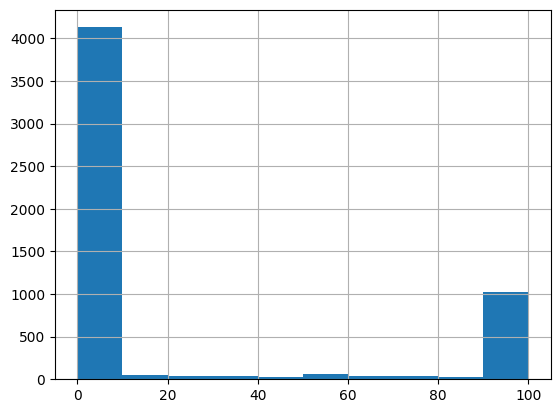

In [90]:
df_values["percent"].hist()

In [91]:
df_values[df_values["percent"] == 100][:20]

,count,count_not_ner,percent
Tokens,,,
ПАО,429,429.0,100.0
АО,291,291.0,100.0
Директоров,284,284.0,100.0
2018,192,192.0,100.0
рублей,182,182.0,100.0
Совет,142,142.0,100.0
часов,132,132.0,100.0
Ревизионной,123,123.0,100.0
02,109,109.0,100.0


In [92]:
df_values[df_values["percent"] == 0][:20]

,count,count_not_ner,percent
Tokens,,,
голосов,1303,0.0,0.0
дня,1034,0.0,0.0
вопросу,1019,0.0,0.0
Общества,1001,0.0,0.0
повестки,994,0.0,0.0
%,861,0.0,0.0
Число,655,0.0,0.0
№,592,0.0,0.0
участие,527,0.0,0.0


Здесь каких-то очевидных проблем нет

Найдем случаи, когда у сущности есть середина или конец (префик "I-"), но нет начала (префикс "B-")

In [93]:
def func_error(list_i):
    first = ""
    index_error = []
    for index, i in enumerate(list_i):
        if i.startswith("I-") and i.removeprefix("I-") != first:
            index_error.append(index)

        elif i.startswith("B-"):
            first = i.removeprefix("B-")
    return index_error

In [94]:
df.columns

Index(['DocName', 'Tokens', 'KE_0', 'KE_1', 'KE_2', 'KE_3', 'KE_4', 'Blocks_0', 'Blocks_1', 'Blocks_2', 'Blocks_3'], dtype='object')

In [95]:
index_error = []
col_name = []
for colname in [
    "KE_0",
    "KE_1",
    "KE_2",
    "KE_3",
    "KE_4",
    "Blocks_0",
    "Blocks_1",
    "Blocks_2",
    "Blocks_3",
]:
    errors_index = func_error(df[colname].to_list())
    col_name += [colname] * len(errors_index)
    index_error.extend(errors_index)

In [96]:
pd.DataFrame({"col_name":col_name, "index_error":index_error}).value_counts("col_name")

col_name
Blocks_3    4075
KE_0          25
KE_4          16
KE_3          11
KE_1           4
Name: count, dtype: int64

Больше всего случаев, когда есть префикс серидины или конца, но нет начала в Blocks_3, потому что сам по себе в Blocks_3 размечены очень большие части текста

In [97]:
# изучим первую выявленную ошибку
index = index_error[0]
df.loc[index - 5 : index + 5]

,DocName,Tokens,KE_0,KE_1,KE_2,KE_3,KE_4,Blocks_0,Blocks_1,Blocks_2,Blocks_3
15952,protocol_31.05.2019.html.txt,портфель,O,O,O,O,O,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,I-4_1_ОбсуждениеПовестки->Выслушали_Обсудили
15953,protocol_31.05.2019.html.txt,составил,O,O,O,O,O,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,I-4_1_ОбсуждениеПовестки->Выслушали_Обсудили
15954,protocol_31.05.2019.html.txt,137,O,O,O,B-Цифры_Кол-во,B-Цифры-цифры_номером,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,I-4_1_ОбсуждениеПовестки->Выслушали_Обсудили
15955,protocol_31.05.2019.html.txt,",",O,O,O,I-Цифры_Кол-во,I-Цифры-цифры_номером,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,I-4_1_ОбсуждениеПовестки->Выслушали_Обсудили
15956,protocol_31.05.2019.html.txt,8,O,O,O,I-Цифры_Кол-во,I-Цифры-цифры_номером,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,I-4_1_ОбсуждениеПовестки->Выслушали_Обсудили
15957,protocol_31.05.2019.html.txt,млрд,I-Сумма,O,O,O,O,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,I-4_1_ОбсуждениеПовестки->Выслушали_Обсудили
15958,protocol_31.05.2019.html.txt,.,I-Сумма,O,O,O,O,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,I-4_1_ОбсуждениеПовестки->Выслушали_Обсудили
15959,protocol_31.05.2019.html.txt,руб,I-Сумма,B-Сумма-валюта,O,O,O,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,I-4_1_ОбсуждениеПовестки->Выслушали_Обсудили
15960,protocol_31.05.2019.html.txt,.,O,O,O,O,O,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,I-4_1_ОбсуждениеПовестки->Выслушали_Обсудили
15961,protocol_31.05.2019.html.txt,Портфель,O,O,O,O,O,4_Блок_Обсуждение,O,4_1_ОбсуждениеПовестки,I-4_1_ОбсуждениеПовестки->Выслушали_Обсудили


В "KE_0" неверно размечена сумма

Пологаю, что лучший способ выявления ошибок в таких данных и задчах это наложение разметки на текст и просмотр полученного документа с разметкой. Однако у меня не получилось повторить токенезацию исходных документов (пробовал nltk, spacy, split). 